<a href="https://colab.research.google.com/github/Irinoise/test-classification-task/blob/main/HSE_test_for_final_proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# обновление для sklearn, чтобы при загрузке датасета можно было использовать встроенный функционал получения набора данных в формате DataFrame
!pip install -U scikit-learn

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.7/dist-packages (0.24.2)


In [ ]:
import warnings
warnings.simplefilter("ignore")

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import xgboost
from sklearn.utils import shuffle
from sklearn.datasets import load_breast_cancer, load_digits
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

In [ ]:
data_digits = load_digits(return_X_y=True)
X, y = shuffle(data_digits[0], data_digits[1], random_state=42)

Загруженный датасет содержит 1797 объектов и 64 "признака". В описании датасета указано, что в наборе данных представлены 10 классов, в каждом из которых примерно по 180 объектов. Построим `countplot` и наглядно увидим, что классы сбалансированы.

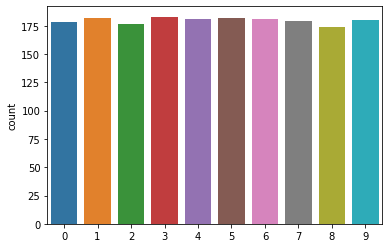

In [ ]:
ax = sns.countplot(y)

Используем метод `cross_validate` для создания модели с кросс-валидацией, посчитаем метрики:
*   Accuracy
*   Precision
*   Recall
*   F-score
*   ROC-AUC

Поскольку в данном случае решается задача многоклассовой классификации, то для некоторых из метрик необходимо указать усреднение. Выбор был сделан в пользу macro-усреднения, поскольку нет дисбаланса классов и все классы равнозначны.

In [ ]:
model_XGB = xgboost.XGBClassifier()
model_LR = LogisticRegression()

scores = ('accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'roc_auc_ovr')

cv_XGB_scores = cross_validate(model_XGB, X, y, cv=10, scoring=scores)
cv_LR_scores = cross_validate(model_LR, X, y, cv=10, scoring=scores)

In [ ]:
print(f'Mean Accuracy: XGB = {np.mean(cv_XGB_scores["test_accuracy"])}, LR = {np.mean(cv_LR_scores["test_accuracy"])}')
print(f'Mean Precision: XGB = {np.mean(cv_XGB_scores["test_precision_macro"])}, LR = {np.mean(cv_LR_scores["test_precision_macro"])}')
print(f'Mean Recall: XGB = {np.mean(cv_XGB_scores["test_recall_macro"])}, LR = {np.mean(cv_LR_scores["test_recall_macro"])}')
print(f'Mean F-score: XGB = {np.mean(cv_XGB_scores["test_f1_macro"])}, LR = {np.mean(cv_LR_scores["test_f1_macro"])}')
print(f'Mean ROC-AUC: XGB = {np.mean(cv_XGB_scores["test_roc_auc_ovr"])}, LR = {np.mean(cv_LR_scores["test_roc_auc_ovr"])}')

Mean Accuracy: XGB = 0.9621570453134698, LR = 0.9638144009931718
Mean Precision: XGB = 0.9640162326493595, LR = 0.9664884610143897
Mean Recall: XGB = 0.9623288613691091, LR = 0.9637736498108014
Mean F-score: XGB = 0.9621582318145785, LR = 0.9638017445213091
Mean ROC-AUC: XGB = 0.9991170849419977, LR = 0.9988635029848002


Получаем следующие средние показатели по озвученным выше метрикам:

|      |  XGB |LogisticRegression|
|------|------|-------------------|
|   **Accuracy**  | 0.962| 0.963|
|   **Precision**  | 0.964| 0.966|
|   **Recall**  | 0.962| 0.963|
|   **F-score**  | 0.962| 0.963|
|   **ROC-AUC**  | 0.999| 0.998|

Данный классификатор (на основе обеих моделей) показывает очень высокие (даже вызывающие подозрение) значения ROC-AUC, что говорит о том, что классификатор научился отделять один класс от другого.

Построим `confusion matrix`, чтобы понять, какие ошибки совершает классификатор, что приводит к подозрительным значениям метрик оценки качества (несколько заниженные значения accuracy/precision/recall/f-score при очень высоких значениях ROC-AUC).

Поскольку значения метрик оценки качества схожи для обеих моделей, построим матрицу ошибок для одной из них.

In [ ]:
y_pred = cross_val_predict(model_XGB, X, y, cv=10)

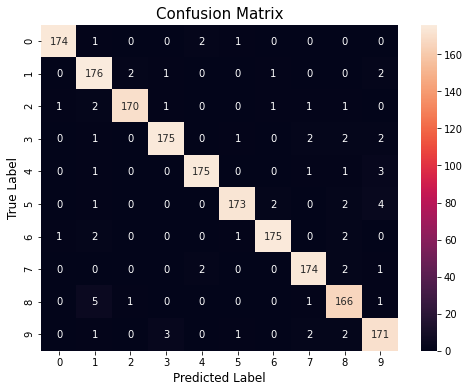

In [ ]:
conf_mat = confusion_matrix(y, y_pred)

fig, ax = plt.subplots(figsize=(8,6))
ax = sns.heatmap(conf_mat, annot=True, fmt='d')

plt.title('Confusion Matrix', fontsize=15)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)

plt.show()

По матрице ошибок видим, что классификатор действительно хорошо отделяет один класс от другого, причем это справедливо для всех 10 классов – все они определяются одинаково хорошо. Тогда можем сделать вывод, что заниженные значения остальных метрик складываются из единичных ошибок, когда каждый класс "разово" определяется как какой-то другой из 10.

Однако, всё ещё обращаем внимание, что классификатор хорошо отделяет классы друг от друга, поэтому такой классификатор можем считать устойчивым.

Создадим модель с использованием одного разбиения train-test в соотношении 70:30 и посчитаем те же метрики.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

Реализуем метод для подсчета значений метрик оценки качества моделей.

In [ ]:
def scoring (y_true, y_hat):
  accuracy = accuracy_score(y_true, y_hat)
  precision = precision_score(y_true, y_hat, average='macro')
  recall = recall_score(y_true, y_hat, average='macro')
  f_score = f1_score(y_true, y_hat, average='macro')
  labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
  roc_auc = roc_auc_score(label_binarize(y_true, classes=labels), label_binarize(y_hat, classes=labels), multi_class='ovr')
  print(f'Accuracy = {accuracy}, Precision = {precision}, Recall = {recall}, F_score = {f_score}, ROC-AUC = {roc_auc}')

Обучим модели и посчитаем значения метрик.

In [ ]:
models = [model_XGB, model_LR]

for model in models:
  model.fit(X_train, y_train)
  y_pred_train = model.predict(X_train)
  y_pred_test = model.predict(X_test)
  print(f'Train scores:')
  scoring(y_train, y_pred_train)
  print(f'Test scores:')
  scoring(y_test, y_pred_test)

Train scores:
Accuracy = 1.0, Precision = 1.0, Recall = 1.0, F_score = 1.0, ROC-AUC = 1.0
Test scores:
Accuracy = 0.9444444444444444, Precision = 0.9422575955291588, Recall = 0.9426214310728129, F_score = 0.9417066553429134, ROC-AUC = 0.9682442479804646
Train scores:
Accuracy = 1.0, Precision = 1.0, Recall = 1.0, F_score = 1.0, ROC-AUC = 1.0
Test scores:
Accuracy = 0.9574074074074074, Precision = 0.9570090973259371, Recall = 0.9560929030251751, F_score = 0.9558808745896741, ROC-AUC = 0.9756871830061737


Для одного разбиения train-test получаем следующие значения метрик (на тестовой выборке):

|      |  XGB |LogisticRegression|
|------|------|-------------------|
|   **Accuracy**  | 0.944| 0.957|
|   **Precision**  | 0.942| 0.957|
|   **Recall**  | 0.942| 0.956|
|   **F-score**  | 0.941| 0.955|
|   **ROC-AUC**  | 0.968| 0.975|

Из результатов вывода программы видно, что на обучающей выборке классификатор (на основе обеих моделей) определяет классы без ошибок (все метрики = 1.0), однако на тестовой выборке значения заметно ниже, что свидетельствует о переобучении модели. Такому классификатору мы доверять не можем.

Загрузим и рассмотрим второй датасет.

In [ ]:
X_cancer, y_cancer = load_breast_cancer(return_X_y=True, as_frame=True)
X_cancer, y_cancer = shuffle(X_cancer, y_cancer, random_state=42)

Загруженный датасет состоит из 569 объектов и 30 признаков. В датасете представлены объекты 2 классов.

Проверим на наличие пустых значений и посмотрим на баланс классов.

In [ ]:
X_cancer.isnull().sum()

mean radius                0
mean texture               0
mean perimeter             0
mean area                  0
mean smoothness            0
mean compactness           0
mean concavity             0
mean concave points        0
mean symmetry              0
mean fractal dimension     0
radius error               0
texture error              0
perimeter error            0
area error                 0
smoothness error           0
compactness error          0
concavity error            0
concave points error       0
symmetry error             0
fractal dimension error    0
worst radius               0
worst texture              0
worst perimeter            0
worst area                 0
worst smoothness           0
worst compactness          0
worst concavity            0
worst concave points       0
worst symmetry             0
worst fractal dimension    0
dtype: int64

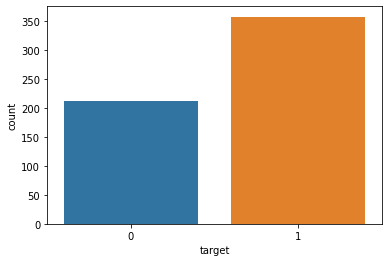

In [ ]:
ax = sns.countplot(y_cancer)

Видим, что классы несколько несбалансированы. Однако, было принято решение не заниматься балансировкой классов, поскольку явных проблем по причине дисбаланса не возникло, а балансировка привела бы к а) уменьшению размера и без того небольшого датасета или б) появлению синтетических объектов.

Начнем с построения модели на одном разбиении train-test в соотношении 70:30.

Масштабируем признаки при помощи `StandardScaler`.

In [ ]:
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_cancer, y_cancer, test_size=0.3, random_state=42, shuffle=True)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_c)
X_test_scaled = scaler.transform(X_test_c)

model_XGB_c = xgboost.XGBClassifier(objective='binary:logistic')

models_c = [model_XGB_c, model_LR]

def scoring_c (y_true, y_hat):
  accuracy = accuracy_score(y_true, y_hat)
  precision = precision_score(y_true, y_hat)
  recall = recall_score(y_true, y_hat)
  f_score = f1_score(y_true, y_hat)
  roc_auc = roc_auc_score(y_true, y_hat)
  print(f'Accuracy = {accuracy}, Precision = {precision}, Recall = {recall}, F_score = {f_score}, ROC-AUC = {roc_auc}')

for model in models_c:
  model.fit(X_train_scaled, y_train_c)
  y_pred_test_c = model.predict(X_test_scaled)
  y_pred_train_c = model.predict(X_train_scaled)
  print(f'Train scores:')
  scoring_c(y_train_c, y_pred_train_c)
  print(f'Test scores:')
  scoring_c(y_test_c, y_pred_test_c)

Train scores:
Accuracy = 1.0, Precision = 1.0, Recall = 1.0, F_score = 1.0, ROC-AUC = 1.0
Test scores:
Accuracy = 0.935672514619883, Precision = 0.9203539823008849, Recall = 0.9811320754716981, F_score = 0.949771689497717, ROC-AUC = 0.9213352685050799
Train scores:
Accuracy = 0.9899497487437185, Precision = 0.9881422924901185, Recall = 0.9960159362549801, F_score = 0.992063492063492, ROC-AUC = 0.9878038864948369
Test scores:
Accuracy = 0.9649122807017544, Precision = 0.9464285714285714, Recall = 1.0, F_score = 0.9724770642201834, ROC-AUC = 0.9538461538461538


Для одного разбиения train-test получаем следующие значения метрик (на тестовой выборке):

|      |  XGB |LogisticRegression|
|------|------|-------------------|
|   **Accuracy**  | 0.935| 0.964|
|   **Precision**  | 0.920| 0.946|
|   **Recall**  | 0.981| 1.0|
|   **F-score**  | 0.949| 0.972|
|   **ROC-AUC**  | 0.921| 0.953|

По результатам видно, что получилися неустойчивый классификатор (при использовании обеих моделей): при высоком значении Recall (для LR даже равном 1.0) классификатор показывает довольно низкое значение Precision, что говорит о том, что классификатор имеет много FP-ошибок, что в случае с набором данных о заболевании раком имеет ключевое значение, поскольку такой классификатор "пометит" пациентов со злокачественной опухолью доброкачественной (в рассматриваемом датасете классом 0 помечена злокачественная опухоль, классом 1 – доброкачественная).

In [ ]:
c_scores = ('accuracy', 'precision', 'recall', 'f1', 'roc_auc')

X_cancer_scaled = scaler.transform(X_cancer)

cv_XGB_c_scores = cross_validate(model_XGB_c, X_cancer_scaled, y_cancer, cv=5, scoring=c_scores)
cv_LR_c_scores = cross_validate(model_LR, X_cancer_scaled, y_cancer, cv=5, scoring=c_scores)

print(f'Mean Accuracy: XGB = {np.mean(cv_XGB_c_scores["test_accuracy"])}, LR = {np.mean(cv_LR_c_scores["test_accuracy"])}')
print(f'Mean Precision: XGB = {np.mean(cv_XGB_c_scores["test_precision"])}, LR = {np.mean(cv_LR_c_scores["test_precision"])}')
print(f'Mean Recall: XGB = {np.mean(cv_XGB_c_scores["test_recall"])}, LR = {np.mean(cv_LR_c_scores["test_recall"])}')
print(f'Mean F-score: XGB = {np.mean(cv_XGB_c_scores["test_f1"])}, LR = {np.mean(cv_LR_c_scores["test_f1"])}')
print(f'Mean ROC-AUC: XGB = {np.mean(cv_XGB_c_scores["test_roc_auc"])}, LR = {np.mean(cv_LR_c_scores["test_roc_auc"])}')

Mean Accuracy: XGB = 0.9630957925787922, LR = 0.9771464058376029
Mean Precision: XGB = 0.9642302827620212, LR = 0.9778919330289193
Mean Recall: XGB = 0.9776212832550861, LR = 0.9860328638497652
Mean F-score: XGB = 0.9708229509953649, LR = 0.981895881895882
Mean ROC-AUC: XGB = 0.9912696679647219, LR = 0.9943951608011549


Получаем следующие средние показатели по озвученным выше метрикам:

|      |  XGB |LogisticRegression|
|------|------|-------------------|
|   **Accuracy**  | 0.963| 0.977|
|   **Precision**  | 0.964| 0.977|
|   **Recall**  | 0.977| 0.986|
|   **F-score**  | 0.970| 0.981|
|   **ROC-AUC**  | 0.991| 0.994|

Здесь мы снова видим высокое значение метрики ROC-AUC, что означает, что классификатор совершает мало ошибок при разделении классов. Однако в отличие от предыдущего случая, показатели качества моделей отличаются у XGB и LR.

Посмотрим на матрицу ошибок.

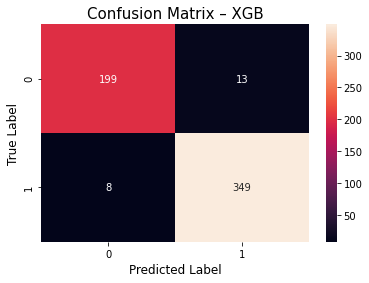

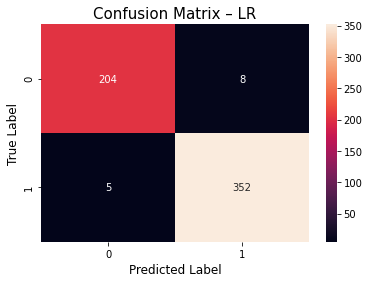

In [ ]:
i = 0

for model in models_c:
  y_pred = cross_val_predict(model, X_cancer_scaled, y_cancer, cv=5)
  conf_mtrx = confusion_matrix(y_cancer, y_pred)
  ax = sns.heatmap(conf_mtrx, annot=True, fmt='d')
  if i == 0:
    ax.set_title('Confusion Matrix – XGB', fontsize=15)
  else:
    ax.set_title('Confusion Matrix – LR', fontsize=15)
  ax.set_xlabel('Predicted Label', fontsize=12)
  ax.set_ylabel('True Label', fontsize=12)
  plt.show()
  i += 1


Видим, что количество FP-ошибок модели XGB сильно выше количества таких ошибок в модели LR. Поэтому устойчивым (хоть и неидеальным) классификатором в данном случае можем считать модель на основе логистической регрессии.